# 2nd Assigment: X-ray image classification

Data: https://lasalleuniversities-my.sharepoint.com/:u:/g/personal/juanmanuel_g_salle_url_edu/EVk1RlzBs-NDk3Iu_jkNLZQBPTCB7cvuuwFT-jjRud6LvA?e=xCbKKc 

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.


In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg
chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg
chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg
chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg
chest_xray/test/PNEUMONIA/person1647_virus_2848.jpeg
chest_xray/test/PNEUMONIA/person1675_virus_2891.jpeg
chest_xray/test/PNEUMONIA/person89_bacteria_440.jpeg
chest_xray/test/PNEUMONIA/person35_virus_80.jpeg
chest_xray/test/PNEUMONIA/person122_bacteria_582.jpeg
chest_xray/test/PNEUMONIA/person119_bacteria_565.jpeg
chest_xray/test/PNEUMONIA/person1662_virus_2875.jpeg
chest_xray/test/PNEUMONIA/person85_bacteria_422.jpeg
chest_xray/test/PNEUMONIA/person1669_virus_2884.jpeg
chest_xray/test/PNEUMONIA/person39_virus_85.jpeg
chest_xray/test/PNEUMONIA/person36_virus_81.jpeg
chest_xray/test/PNEUMONIA/person134_bacteria_640.jpeg
chest_xray/test/PNEUMONIA/person138_bacteria_659.jpeg
chest_xray/test/PNEUMONIA/person92_bacteria_450.jpeg
chest_xray/test/PNEUMONIA/person34_virus_76.jpeg
ch

## Importing the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
import tensorflow
from tensorflow.keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

## Loading the Dataset

In [4]:
train = get_training_data('chest_xray/train')
test = get_training_data('chest_xray/test')
val = get_training_data('chest_xray/val')

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


## Data Visualization & Preprocessing

The data seems imbalanced . To increase the no. of training examples, **you should use data augmentation**

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

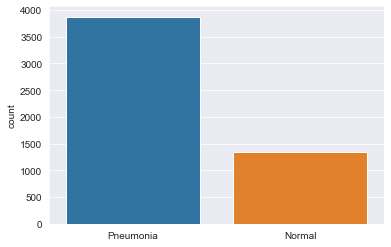

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

Text(0.5, 1.0, 'NORMAL')

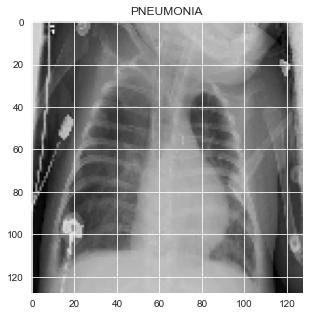

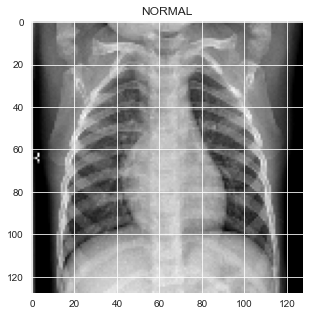

In [6]:
# Previewing the images of both the classes
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
# Divide into feature and label

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
x_train2 = x_train
y_train2 = y_train

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# Shape for further control
image_shape = x_train[0].shape[0] # Since x and y are same
image_c = 1 # 1D since is black&white

In [10]:
# 0 is pneumonia, 1 is normal

## Exercise

### Data Augmentation

In order to avoid overfitting problem, it is needed to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

**For the data augmentation, please choose**:

+ rotation_range [float]
+ zoom_range [float]
+ width_shift_range [float]
+ height_shift_range [float]
+ Flip images horizontally [boolean]

In [11]:
x_train = x_train.reshape(-1, img_size, img_size, image_c)

In [12]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 0.2,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = 0.2,  # randomly flip images
        vertical_flip= False)  # randomly flip images


datagen.fit(x_train)

Based on the unbalance, *normal* images are like a third part of the ones classified as *pneumonia*. For this reason, the following cell will create 2 images from each one applying some of the image generator functionalities.

In [13]:
print('Original test images size:', len(x_train))
gen_images = []
gen_images_label = []
normal_test = 0
pneumonia_test = 0
for image_index in range(0, len(x_train)):
    # Iterate through all training instances and just apply the function for those who are 'normal' (label 1)
    if y_train[image_index] == 1:
        # Apply the process 
        count = 0
        normal_test +=1
        X = x_train[image_index].reshape((1,) + x_train[image_index].shape) # Converting into 4 dimension array

        for batch in datagen.flow(X, batch_size=5):
            gen_images.append(batch)
            gen_images_label.append(1)
            count += 1
            if count >=2:
                break
    else:
        pneumonia_test +=1
print('nº of samples obtained through data augmentation (normal):',len(gen_images))
print('Original nº of samples, normal type:', normal_test)
print('nº of samples test, pneumonia:', pneumonia_test)

Original test images size: 5216
nº of samples obtained through data augmentation (normal): 2682
Original nº of samples, normal type: 1341
nº of samples test, pneumonia: 3875


In [14]:
3875/(2682+1341+3875)

0.4906305393770575

New images are generated and stored in *gen_images* for counting purposes. Despite the partition into *train* and *test* has been done previously and the unbalance of the data itself in both partitions is still existing, does not affect to *test*, why?

This unbalance between classes affects on **training**. Afterwards, the model will just predict based on the image to classify. Hence, if the training instances are balanced, it's enough.

Having a look into the initial proportion (3875 for pneumonia, 1341 for normal images) it's necessary to triple the *normal* images to obtain a balanced proportion (49% for pneumonia and 51% for normal images).

Images are generated and stored in *gen_images* but are stored in **tensors** (size, x,y,D) so it's necessary to reshape them again to 3D vectors in order to store them into training set accordingly the rest of the images, but before this step, let's have to a generated image.

Image shape: (128, 128, 1)


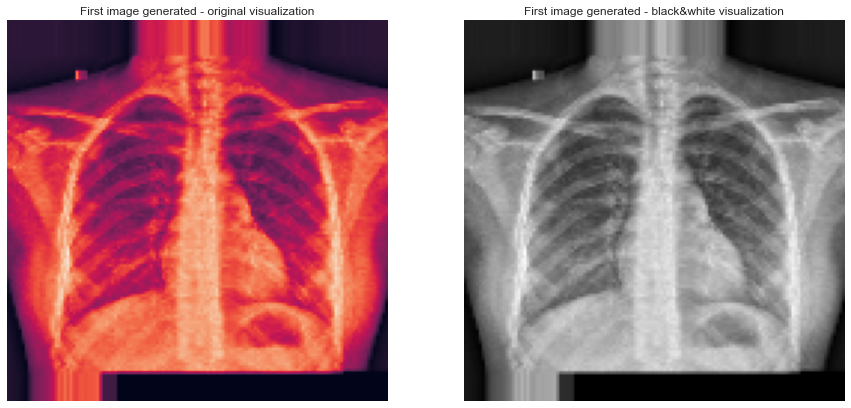

In [15]:
test_image = gen_images[0].reshape(img_size,img_size,1)

plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
plt.title('First image generated - original visualization')
plt.axis('off')
plt.imshow(test_image)


plt.subplot(1,2,2)
plt.title('First image generated - black&white visualization')
plt.axis('off')
plt.imshow(test_image, cmap='gray') # cmap allows the black&white colours, otherwise the image uses other colours



print('Image shape:', test_image.shape)

Both images are the same, just modifying *cmap* parameter modifies the visualization to a 'more common' radiography colour.

### Further steps
Now it's necessary to add this images to the training set. In order to proceed, it's necessary to add images *after* reshaping them from a 4D tensor to a 3D vector.

Once this process is done, **Deep Learning** begins by defining **neural network architecture**, optimize hyperparameters and results evaluation.

In [16]:
# List conversion to simplify additions
x_train = list(x_train)
y_train = list(y_train)

print('Original training dataset, X:',len(x_train))
print('Original training dataset, Y:', len(y_train))

for i in gen_images:
    x_train.append(i.reshape(img_size,img_size,1))
    y_train.append(1)
    
print('Final training dataset, X:',len(x_train))
print('Final training dataset, Y:',len(y_train))

Original training dataset, X: 5216
Original training dataset, Y: 5216
Final training dataset, X: 7898
Final training dataset, Y: 7898


In [17]:
# To shuffle data 
data = {'Images':x_train ,
        'label': y_train
        }

df = pd.DataFrame(data, columns = ['Images', 'label'])

df = df.sample(frac=1).reset_index(drop=True)

Now it's time to reselect x_train and y_train from dataset, being the data shuffled

In [18]:
x_train = list(df.Images)
y_train = list(df.label)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [19]:
# resize data for deep learning 

x_train = x_train.reshape(-1, img_size, img_size, image_c)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, image_c)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, image_c)
y_test = np.array(y_test)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'New class balance: Data augmentation')

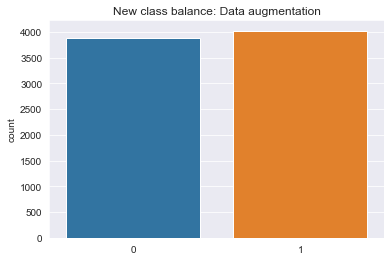

In [20]:
sns.countplot(y_train)    
plt.title('New class balance: Data augmentation')

### Design and train a convolutional neural network for classifying X-ray images

In [21]:
# Graphic display function
def model_curves(model_fit):
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']

    loss = model_fit.history['loss']
    val_loss = model_fit.history['val_loss']


    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlim([0, epochs])
    plt.ylim([0,1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlim([0, epochs])
    plt.ylim([0,1])
    plt.title('Training and Validation Loss')
    plt.show()

In [22]:
pool_size =(3, 3)

model0 = Sequential()

model0.add(Conv2D(8, 5, padding='same', activation='relu', input_shape=(img_size, img_size, 1))) 
model0.add(BatchNormalization())
model0.add(MaxPooling2D(pool_size=pool_size))

model0.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=(img_size, img_size, 1))) 
model0.add(BatchNormalization())
model0.add(MaxPooling2D(pool_size=pool_size))

model0.add(Flatten())
model0.add(Dropout(0.5))
model0.add(Dense(1, activation='sigmoid'))

# Building optimizers
adam_tuned = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

sgd_tuned = tensorflow.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.1, nesterov=False, name="SGD" # momentum controls learning rate 'acceleration'
)

# Compile the model to further training
model0.compile(optimizer=sgd_tuned, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Defining the training loops
epochs = 10

# Training the model
model0_fit = model0.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Train on 7898 samples, validate on 624 samples
Epoch 1/10
7898/7898 [==============================] - 75s 9ms/sample - loss: 0.6188 - accuracy: 0.8731 - val_loss: 1.0304 - val_accuracy: 0.6571
Epoch 2/10
7898/7898 [==============================] - 74s 9ms/sample - loss: 0.2417 - accuracy: 0.9358 - val_loss: 0.8718 - val_accuracy: 0.7276
Epoch 3/10
7898/7898 [==============================] - 74s 9ms/sample - loss: 0.1910 - accuracy: 0.9450 - val_loss: 3.1588 - val_accuracy: 0.6458
Epoch 4/10
7898/7898 [==============================] - 74s 9ms/sample - loss: 0.1598 - accuracy: 0.9532 - val_loss: 9.9924 - val_accuracy: 0.3750
Epoch 5/10
7898/7898 [==============================] - 74s 9ms/sample - loss: 0.1395 - accuracy: 0.9614 - val_loss: 7.5832 - val_accuracy: 0.6250
Epoch 6/10
7898/7898 [==============================] - 74s 9ms/sample - loss: 0.1432 - accuracy: 0.9600 - val_loss: 0.5615 - val_accuracy: 0.8462
Epoch 7/10
7898/7898 [==============================] - 74s 9ms/sample 

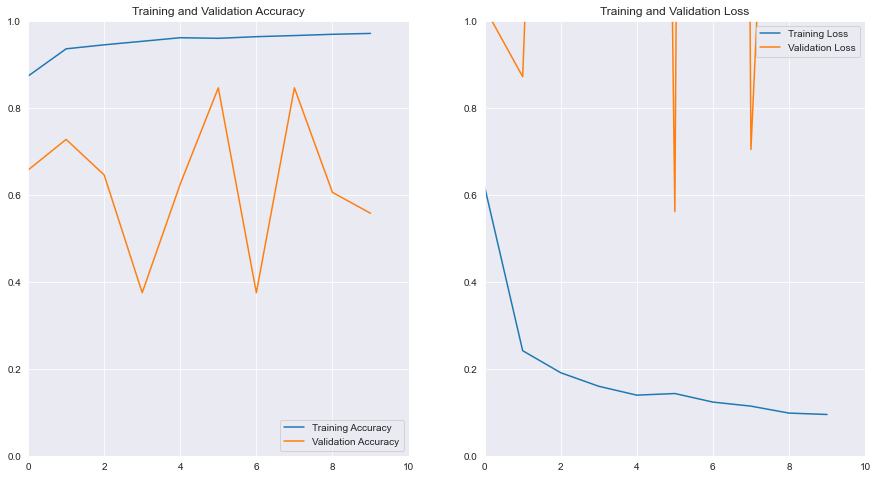

In [23]:
model_curves(model0_fit)

This model is not fitting at all, curves look 'ugly' and it's clearly overfitting. Let's spend some time building a deeper model and a simpler one with reduced learning rate to avoid this overfitting.

In [24]:
from tensorflow import keras
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])

# Building optimizers
adam_tuned = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

sgd_tuned = tensorflow.keras.optimizers.SGD(
    learning_rate=0.05, momentum=0.1, nesterov=False, name="SGD" # momentum controls learning rate 'acceleration'
)

rms = tensorflow.keras.optimizers.RMSprop(
    learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop'
)

# Compile the model to further training
model.compile(optimizer=sgd_tuned, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Defining the training loops
epochs = 5

# Training the model
model_fit = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Train on 7898 samples, validate on 624 samples
Epoch 1/5
7898/7898 [==============================] - 232s 29ms/sample - loss: 0.3562 - accuracy: 0.8435 - val_loss: 0.8759 - val_accuracy: 0.6474
Epoch 2/5
7898/7898 [==============================] - 232s 29ms/sample - loss: 0.1561 - accuracy: 0.9416 - val_loss: 0.4179 - val_accuracy: 0.8317
Epoch 3/5
7898/7898 [==============================] - 232s 29ms/sample - loss: 0.1243 - accuracy: 0.9548 - val_loss: 0.5403 - val_accuracy: 0.7917
Epoch 4/5
7898/7898 [==============================] - 230s 29ms/sample - loss: 0.0978 - accuracy: 0.9624 - val_loss: 0.4819 - val_accuracy: 0.8237
Epoch 5/5
7898/7898 [==============================] - 231s 29ms/sample - loss: 0.0895 - accuracy: 0.9680 - val_loss: 0.6081 - val_accuracy: 0.7997


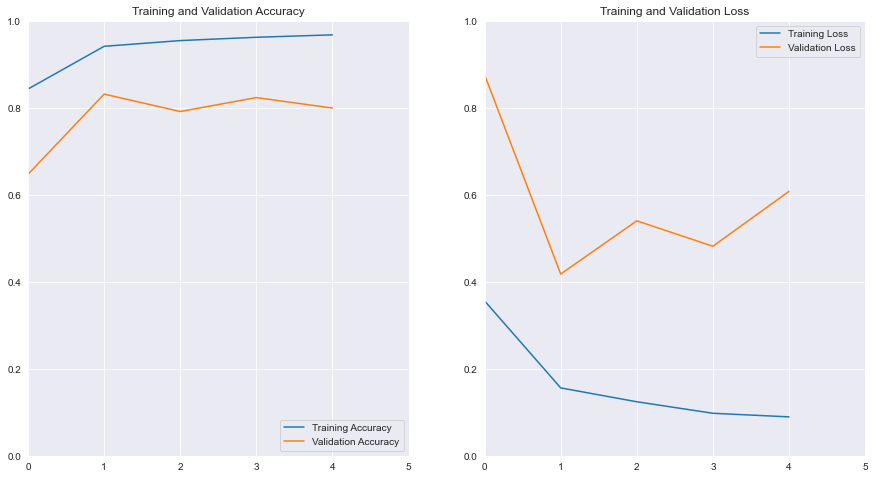

In [25]:
model_curves(model_fit)

This model does not fit at all. Notice over 3 epochs *validation accuracy* and *validation loss* start overfitting, highly impacted by the learning rate.

For this purposes, a simpler model is created with a smaller learning rate, allowing the algorithm to iterate slowly but surely. Since this steps are reduced by a 100 factor, *epochs* are increased to let the model converge.

In [44]:
pool_size =(3, 3)

model2 = Sequential()

model2.add(Conv2D(16, 5, padding='same', activation='relu', input_shape=(img_size, img_size, 1))) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=pool_size))
model2.add(Dropout(0.1))

model2.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=(img_size, img_size, 1))) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=pool_size))
model2.add(Dropout(0.1))


model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

# Building optimizers
adam_tuned = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

sgd_tuned = tensorflow.keras.optimizers.SGD(
    learning_rate=0.00001, momentum=0.1, nesterov=False, name="SGD" # momentum controls learning rate 'acceleration'
)

# Compile the model to further training
model2.compile(optimizer=sgd_tuned, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Defining the training loops
epochs = 10

# Training the model
model2_fit = model2.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))

Train on 7898 samples, validate on 624 samples
Epoch 1/10
7898/7898 [==============================] - 120s 15ms/sample - loss: 1.4414 - accuracy: 0.4815 - val_loss: 0.6918 - val_accuracy: 0.5256
Epoch 2/10
7898/7898 [==============================] - 119s 15ms/sample - loss: 1.2515 - accuracy: 0.5336 - val_loss: 0.6744 - val_accuracy: 0.5913
Epoch 3/10
7898/7898 [==============================] - 118s 15ms/sample - loss: 1.1234 - accuracy: 0.5725 - val_loss: 0.5877 - val_accuracy: 0.6971
Epoch 4/10
7898/7898 [==============================] - 118s 15ms/sample - loss: 1.0313 - accuracy: 0.6055 - val_loss: 0.5312 - val_accuracy: 0.7420
Epoch 5/10
7898/7898 [==============================] - 119s 15ms/sample - loss: 0.9469 - accuracy: 0.6324 - val_loss: 0.5000 - val_accuracy: 0.7692
Epoch 6/10
7898/7898 [==============================] - 119s 15ms/sample - loss: 0.8836 - accuracy: 0.6531 - val_loss: 0.4784 - val_accuracy: 0.7901
Epoch 7/10
7898/7898 [==============================] - 119

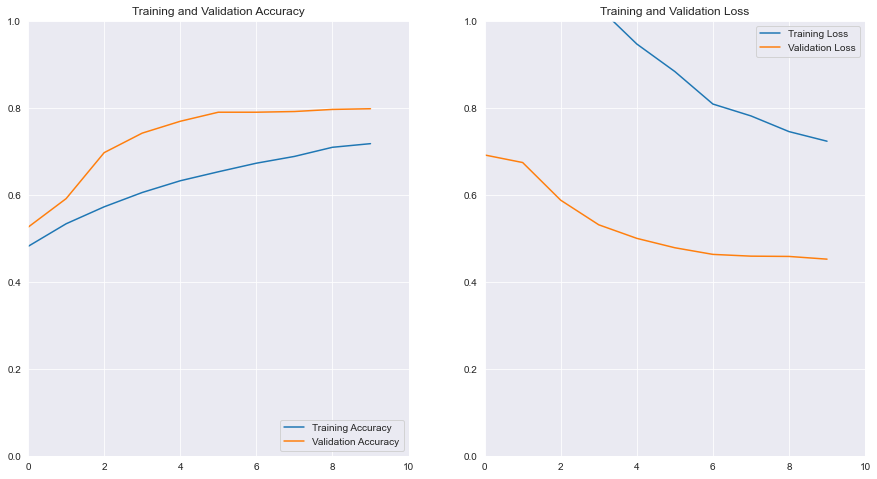

In [45]:
model_curves(model2_fit)

Despite this model is far away from perfect, classifies quite fine, but there's an undesired effect: accuracy is better than training which might be due to **data augmentation** images.

In this exercise, a few parameters have been tuned for augmenting the data and the model might assume this new images are just copies from the existing ones.

Also, the dropout might also affect since some dropout layers are added to the model, causing 0.1, 0.1, 0.5 dropout, meaning the network had less neurons for training than for test.

### Plot the confusion matrix

To do this, it's necessary to predict classes for **validation dataset**, where 8 images of each class are available.

Since three different models with different approaches have been developed, matrices will be displayed.

<AxesSubplot:title={'center':'Third model, small learning rate'}>

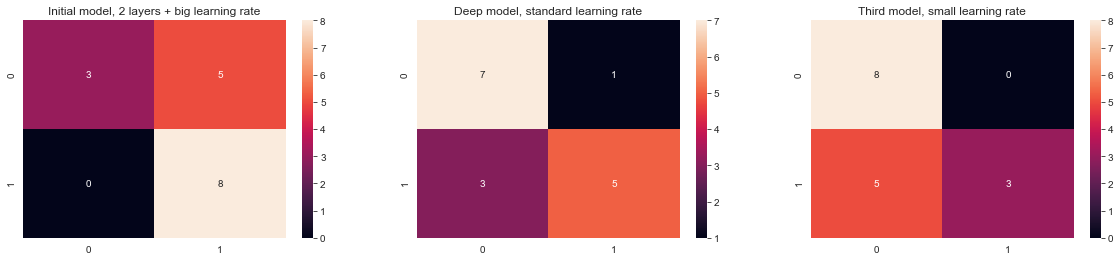

In [46]:
# 0 model - simpler with great learning rate
predicted0 = model0.predict_classes(x_val)
conf_m0 = confusion_matrix(y_val, predicted0)

# 1st model - deeper with greater learning rate
predicted = model.predict_classes(x_val)
# Build confusion matrix and visualize it as a heatmap to increase readability
conf_m1 = confusion_matrix(y_val, predicted)

# 2nd model - simpler with smaller learning rate
predicted2 = model2.predict_classes(x_val)
# Build confusion matrix and visualize it as a heatmap to increase readability
conf_m2 = confusion_matrix(y_val, predicted2)

plt.figure(figsize = (20,4))

plt.subplot(1, 3, 1)
plt.title('Initial model, 2 layers + big learning rate')
sns.heatmap(conf_m0, annot=True)

plt.subplot(1, 3, 2)
plt.title('Deep model, standard learning rate')
sns.heatmap(conf_m1, annot=True)

plt.subplot(1, 3, 3)
plt.title('Third model, small learning rate')
sns.heatmap(conf_m2, annot=True)


### Results observation
In this project the objective is being able to classify whether a radiography is from a patient with pneumonia or not. Since this illness is one of the highest causes of death arround the world, the best way to interpret confusion matrices is to **classify correctly the most pneumonia cases**.

This interpretation is quite simple: it's necessary to find out which patients are suffering a disease to treat them (true positive, 0,0 in this case) because if the model classifies someone healty, after some tests the doctors would determine this patient no longer needs to be at the hospital, causing just a waste of time. Otherwise, if a patient with the disease is classified as healthy (false negative, 0,1) could cause serious injuries on him.

Based on this reason, the best model would be the **third one**, classifying correctly all the patients with pneumonia.

Being able to classify correctly is great! but this model has a penalty: more than half of the patients (5/8) who are healty are classified as ill, and they get through some tests in order to check them. This would be fine if hospitals had infinite resources, but that's not what is happening on reality, so if this model is used, the 0 column (all patients classified as sick) would need to be attended at the hospital (over **80%**), causing delays on true positives classification.

Based on this second reasoning, the best model is the **second one**. Despite classification is not perfect (3/4 overall, 88% on pneumonia patients) less patients are classified as false positives, reducing the amount of resources about 20%, which is, overall, better for the hospital and for the patients.